# Import Packages

In [618]:
import tarfile

# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset 

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker

In [619]:
pwd

'/Users/fabienguegan/projects/batch6-workspace/S05 - Recommender Systems/HCKT05 - Recommender Systems'

# Open Data

## beer_metadata

In [726]:
beer_path = os.path.join('data',"beer_metadata.csv")
beer_metadata = pd.read_csv(beer_path)
beer_metadata.head()

,beer_id,beer_name,brewer_id,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,8481,5.4,India Pale Ale &#40;IPA&#41;
1,71716,John Harvards Cristal Pilsner,8481,5,Bohemian Pilsener
2,64125,John Harvards Fancy Lawnmower Beer,8481,5.4,Klsch
3,31544,John Harvards Vanilla Black Velvet Stout,8481,-,Sweet Stout
4,71714,John Harvards American Brown Ale,8481,-,Brown Ale


In [727]:
beer_metadata["beer_id"] = beer_metadata["beer_id"].str.replace(r'\D', '', regex=True)

In [728]:
beer_metadata["beer_id"] = beer_metadata["beer_id"].astype("int64")

In [729]:
beer_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112050 entries, 0 to 112049
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   beer_id     112050 non-null  int64 
 1   beer_name   112050 non-null  object
 2   brewer_id   112050 non-null  int64 
 3   beer_abv    112050 non-null  object
 4   beer_style  112050 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.3+ MB


## test_users

In [629]:
test_users_path = os.path.join('data',"test_users.csv")
test_users = pd.read_csv(test_users_path)
test_users.head()

,user_name
0,wlajwl
1,BigBang
2,GhostFace
3,sbanach
4,IrishBoy


It will be useful later on to have a list of test data users:

In [630]:
users_test = list(test_users["user_name"].unique())
print(f"We are recommending beers for {len(users_test)} users.")

We are recommending beers for 1808 users.


## train_ratings

In [741]:
train_path = os.path.join('data',"train_ratings.csv")
train_ratings = pd.read_csv(train_path)
train_ratings

/var/folders/cj/lhfwc7l13jl7xt4qnkjs65s00000gn/T/ipykernel_5833/3583565778.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_ratings = pd.read_csv(train_path)


,beer_id,user_name,review_score,review_time
0,63836,hopdog,13/20,1157587200
1,63836,TomDecapolis,13/20,1157241600
2,71716,PhillyBeer2112,14/20,958694400
3,64125,TomDecapolis,8/20,1157587200
4,64125,hopdog,8/20,1157587200
...,...,...,...,...
2838369,98518,Snojerk321,11/20,1233964800
2838370,98518,troopie,13/20,1233446400
2838371,98518,Reid,14/20,1233360000
2838372,98518,boFNjackson,14/20,1233100800


In [743]:
train_ratings["beer_id"] = train_ratings["beer_id"].astype(str)

In [744]:
train_ratings["beer_id"] = train_ratings["beer_id"].str.replace(r'\D', '', regex=True)

In [745]:
train_ratings

,beer_id,user_name,review_score,review_time
0,63836,hopdog,13/20,1157587200
1,63836,TomDecapolis,13/20,1157241600
2,71716,PhillyBeer2112,14/20,958694400
3,64125,TomDecapolis,8/20,1157587200
4,64125,hopdog,8/20,1157587200
...,...,...,...,...
2838369,98518,Snojerk321,11/20,1233964800
2838370,98518,troopie,13/20,1233446400
2838371,98518,Reid,14/20,1233360000
2838372,98518,boFNjackson,14/20,1233100800


 # Process and clean data

In [746]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838374 entries, 0 to 2838373
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   beer_id       object
 1   user_name     object
 2   review_score  object
 3   review_time   int64 
dtypes: int64(1), object(3)
memory usage: 86.6+ MB


## To modify the review score to have only the first number (actual rating) 

In [747]:
train_ratings["review_score"] = train_ratings["review_score"].apply(lambda x: int(x.split('/')[0]))

In [748]:
train_ratings

,beer_id,user_name,review_score,review_time
0,63836,hopdog,13,1157587200
1,63836,TomDecapolis,13,1157241600
2,71716,PhillyBeer2112,14,958694400
3,64125,TomDecapolis,8,1157587200
4,64125,hopdog,8,1157587200
...,...,...,...,...
2838369,98518,Snojerk321,11,1233964800
2838370,98518,troopie,13,1233446400
2838371,98518,Reid,14,1233360000
2838372,98518,boFNjackson,14,1233100800


In [749]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838374 entries, 0 to 2838373
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   beer_id       object
 1   user_name     object
 2   review_score  int64 
 3   review_time   int64 
dtypes: int64(2), object(2)
memory usage: 86.6+ MB


# Identify and separate the Users
- Which users are present in the training data?
- Make sure that you identify which test users are present in the training data and which are not.
- Can you use personalized methologies for all users?

In [750]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(train_ratings):,} ratings in total.")

We have 2,838,374 ratings in total.


In [751]:
# How many beers were rated?
print(f" We have {train_ratings['beer_id'].unique().size:,} beers rated.")

 We have 109,821 beers rated.


In [ ]:
# How many users rated at least one beer?
print(f" We have {train_ratings['user_name'].unique().size:,} users that rated at least one beer.")

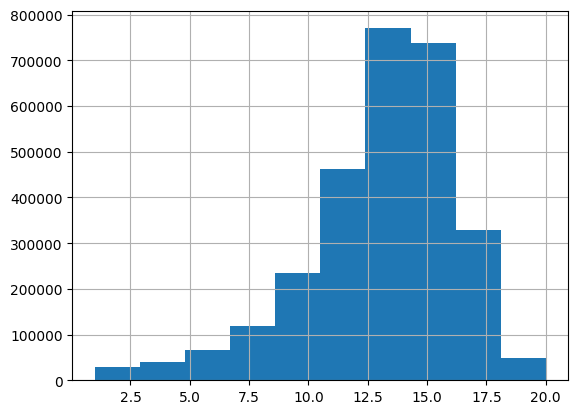

In [752]:
# Plotting the rating distribution.
train_ratings["review_score"].hist();

# Removing columns

In [753]:
train_ratings["review_time"] = pd.to_datetime(train_ratings["review_time"], unit='s')

In [754]:
train_ratings

,beer_id,user_name,review_score,review_time
0,63836,hopdog,13,2006-09-07
1,63836,TomDecapolis,13,2006-09-03
2,71716,PhillyBeer2112,14,2000-05-19
3,64125,TomDecapolis,8,2006-09-07
4,64125,hopdog,8,2006-09-07
...,...,...,...,...
2838369,98518,Snojerk321,11,2009-02-07
2838370,98518,troopie,13,2009-02-01
2838371,98518,Reid,14,2009-01-31
2838372,98518,boFNjackson,14,2009-01-28


In [755]:
## Training data interval range
print(f"The earliest review was written on {train_ratings['review_time'].min()}.")
print(f"The lastest review was written on {train_ratings['review_time'].max()}.")

The earliest review was written on 2000-04-12 00:00:00.
The lastest review was written on 2011-12-31 00:00:00.


For most cases, using old data is a risk. Old data might not reflect accurately the current relationship between features and target. We say that have **[concept drift](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/)** when the relationship between inputs and outputs changes over time. 

In our case, we are going to consider that the userbase's taste do not change significantly over time. In a professional setting, we should back this assumption with data or deal with concept drift.

## Removing columns

The review time column is remove to build the rating matrix

In [756]:
train_ratings_wo_time = train_ratings.drop(columns="review_time")

In [757]:
train_ratings_wo_time

,beer_id,user_name,review_score
0,63836,hopdog,13
1,63836,TomDecapolis,13
2,71716,PhillyBeer2112,14
3,64125,TomDecapolis,8
4,64125,hopdog,8
...,...,...,...
2838369,98518,Snojerk321,11
2838370,98518,troopie,13
2838371,98518,Reid,14
2838372,98518,boFNjackson,14


# Train/validation split

In [758]:
data_train, data_val = train_test_split(train_ratings_wo_time, test_size=0.4, random_state=123)

## Training set

In [759]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_train):,} ratings in total.")

We have 1,703,024 ratings in total.


In [760]:
# How many beer were rated?
print(f" We have {data_train['beer_id'].unique().size:,} beer rated.")

 We have 96,628 beer rated.


In [761]:
# How many users rated at least one beer?
print(f" We have {data_train['user_name'].unique().size:,} users that rated at least one beer.")

 We have 24,452 users that rated at least one beer.


## Validation set

In [762]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_val):,} ratings in total.")

We have 1,135,350 ratings in total.


In [763]:
# How many beers were rated?
print(f" We have {data_val['beer_id'].unique().size:,} beers rated.")

 We have 85,749 beers rated.


In [764]:
# How many users rated at least one beer?
print(f" We have {data_val['user_name'].unique().size:,} users that rated at least one beer.")

 We have 21,316 users that rated at least one beer.


## Select reviews from users with at least 50 positive ratings.

In [765]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 50, min_rating: int = 15):
    """
    Select reviews from users with at least min_nr_reviews reviews with rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["review_score"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["user_name"])["beer_id"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.copy().loc[df_positive["user_name"].isin(test_users_list)]
    
    return df_restrict

data_val_final = select_frequent_reviewers(data_val)
data_val_final.head()

,beer_id,user_name,review_score
637295,124448,TURDFERGUSON,15
1975101,26014,DaSilky1,16
1852940,42015,fiulijn,16
2387645,7086,redlight,17
265807,89707,Drake,15


It will be useful later on to have a list of validation data users:

In [766]:
users_val = data_val_final["user_name"].unique().tolist()
print(f"We are validating recommendations with {len(users_val)} users.")

We are validating recommendations with 1873 users.


## Create the validation recommendations

In [767]:
data_val_final

,beer_id,user_name,review_score
637295,124448,TURDFERGUSON,15
1975101,26014,DaSilky1,16
1852940,42015,fiulijn,16
2387645,7086,redlight,17
265807,89707,Drake,15
...,...,...,...
2639251,105497,tomthompson89,15
2342188,132455,fonefan,15
1956621,63306,watson1977,17
1489385,31053,italarican,15


We will evaluate the outputs of our models with the 50 best rated recipes for each user on the validation data.

In [768]:
# nr of recommendations per user
k_top = 50

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int = 50):

    df_users_kbest = df.copy().groupby(by=[user_col])[rating_col].nlargest(k_top).reset_index()
    df_users_kbest['rank'] = df_users_kbest.groupby(by=[user_col])[rating_col].rank(method="first")
    #df_users_kbest['rank'] = df_users_kbest['rank'].astype(int) - 1
    df_recommendations = df_users_kbest.pivot(index=user_col, columns="rank", values="level_1")
    df_recommendations = df_recommendations.reset_index(drop=False)
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    return df_recommendations

val_recommendations = top_items_per_user(data_val_final, "user_name", "review_score", k_top=k_top)
val_recommendations.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,00cobraR,1093516,1957542,605884,1384976,465343,2796363,2486138,1599962,5043,...,2041597,1472504,2137372,464288,574561,455475,2135346,2499758,614481,163978
1,0o9i,118934,1646628,2079988,251664,468731,2814719,1008658,1137250,241012,...,460731,2239894,1938696,2706077,456853,465965,245256,253110,2819151,462238
2,1010,2449713,1487079,2408959,712978,2082234,2562188,2408351,1753452,2561922,...,865977,2446597,250691,1766097,2562077,1748043,506728,262064,1114053,230363
3,11026,2376836,2686179,159877,267540,1556598,1531468,164072,1290547,1423626,...,1849322,301543,915413,2376261,1107840,82599,1843939,297945,777075,1554310
4,12many,633160,964744,12041,2139098,265845,1756798,1958323,1597421,119372,...,162700,2482888,2818668,1938860,2146949,2559979,2136524,1943215,2558736,2288793


### Saving recommendations

In [769]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved on file {file_name}.csv.")
    
save_recommendations(val_recommendations, "validation_recommendations")

Recommendations were saved on file validation_recommendations.csv.


## Non-personalized recommendations

In [770]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int = 50,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    non_pers_ratings = data.groupby(by=[item_col])[[rating_col]].agg(aggregation)
    non_pers_ratings.columns = non_pers_ratings.columns.get_level_values(1)
    
    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(data_train, "beer_id", "review_score", k_top=k_top)
print(non_pers_recommendations)

['103183', '10336', '104578', '107379', '109441', '110567', '111712', '111815', '117558', '117560', '127096', '129334', '134709', '13658', '137143', '138346', '140550', '143718', '144128', '144910', '146075', '147738', '151723', '154656', '157136', '157370', '158489', '1831', '18478', '19611', '22971', '26707', '30215', '34595', '41000', '41065', '43531', '52084', '52091', '5422', '57631', '57989', '58775', '69839', '70892', '76679', '78177', '78989', '79482', '83169']


### Output non-personalized solution

In [771]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendation dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_name"])
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    #non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

### Non-personalized recommendations for validation data

In [772]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, non_pers_recommendations)
save_recommendations(non_pers_reco_solution_val, "non_personalized_recommendations_VAL")

Recommendations were saved on file non_personalized_recommendations_VAL.csv.


#### Validation evaluation

In [773]:
## Second argument is the recommendation file to compare
evaluate_solution('non_personalized_recommendations_VAL', 'validation_recommendations')

8.442007185157715e-06

### Non-personalized recommendations for test data

In [774]:
non_pers_reco_solution_test = non_pers_reco_output(test_users["user_name"].to_list(), non_pers_recommendations)
save_recommendations(non_pers_reco_solution_test, "non_personalized_recommendations_TEST")

Recommendations were saved on file non_personalized_recommendations_TEST.csv.


#### test evaluation

We do not have the test_recommendations files to compare with.

# Collaborative filtering

We start by using lightFM Dataset() function to create the user and item mapping that defines the vectorial space of the rating matrix.

In [775]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we use later.
lfmdataset = lfmDataset()
lfmdataset.fit(data_train['user_name'], data_train["beer_id"])

We can check that vectorial space is defined as expected:

In [776]:
num_users, num_items = lfmdataset.interactions_shape()
print('Num users: {:,}, num_items {:,}.'.format(num_users, num_items))

Num users: 24,452, num_items 96,628.


The mapping between external user IDs (the ones in our data) and the internal user IDs can be obtained with method .mapping(). The same applies for items.

In [777]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

Reverses map between external and internal IDs. This is used to get the original IDs from the internal IDs.

In [778]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}

Before create the "rating matrix" with LightFM we need to order the column of the data_train to have the user_name in the first column

In [779]:
data_train = data_train[["user_name","beer_id", "review_score"]]

In [780]:
data_train.head()

,user_name,beer_id,review_score
775174,probstk,10704,9
538685,BeerHawk,61447,15
1255227,bu11zeye,887,11
2674934,yespr,93089,13
2131967,andyhwcinc,22764,18


We now need to create the rating matrix. The equivalent in lightFM is the interactions matrix. We use the build_interactions to create the interaction matrix in the COOrdinate format. The argument is an iterable of (user_id, item_id) or (user_id, item_id, weight)), where weight is what we call rating.

In [781]:
(interactions, weights) = lfmdataset.build_interactions((row for row in data_train.values))

print(repr(interactions))

<24452x96628 sparse matrix of type '<class 'numpy.int32'>'
	with 1703024 stored elements in COOrdinate format>


We now define the model that we are going to use to produce our recommendations. We select the warp loss function as it is recommended for optimizing to top of recommendation list (precision@k), which is our case.

In [782]:
lfmodel = LightFM(loss='warp')

We fit the model with our interaction data.

In [783]:
lfmodel.fit(interactions)

With the model trained and the dataset in COO format, we can produce recommendations for a given user (see exercise notebook)

We can use the method .predict to calculate the score (rating) of each item for a given user. We then sort the items' IDs in descending order of rating and select the k_top best items.

But I will jump directly to predict all the validation users

In [784]:
def lightFM_recommendations(dataset,
                            model,
                            user_id_ext_list,
                            non_pers_reco_list,
                            k_top: int = 50,
                            item_features = None):   
    """
    Create output dataframe with recommendations based on dataset, model and list of users.
    
    This function predicts recommendations for users specified in user_id_ext_list that are present in the lightFM dataset.
    New users are recommended the items in the non-personalized list non_per_reco_list.
    
    Parameters:
    -----------
    dataset: lightFM dataset
    
    model: lightFM trained model
    
    user_id_ext_list: list of user external IDs to predict
    
    non_pers_reco: list of non-personalized recommendations ordered from best to worst rated
    
    k_top: number of recommendations to create per user
    
    item_features: lightFM item features
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    assert len(user_id_ext_list) > 0, "User ID list length must be larger than 0."
    
    # Dataset mappings
    user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
    
    # reverse mapping
    item_id_map_reverse = {v: k for k, v in item_id_map.items()}
    user_id_map_reverse = {v: k for k, v in user_id_map.items()}
    
    
    # item internal ids
    item_id_int_list = list(item_id_map.values())
    
    # Split old users (user_id_int_list) from new users (user_id_ext_excluded)
    # Old users are defined in the ratings vectorial space.
    # New users are not defined in the ratings vectorial space.
    # New users receive non-personalized recommendations.
    user_id_int_list = []
    user_id_ext_excluded = []
    
    for user_id_ext in user_id_ext_list:
        try:
            user_id_int_list.append(user_id_map[user_id_ext])
        except:
            user_id_ext_excluded.append(user_id_ext)
    
    # Dataframe to store model recommendations
    model_reco_df = pd.DataFrame()
    
    # Model recommendations
    for user_id in user_id_int_list:
        scores = model.predict(user_id, item_id_int_list, item_features)
        top_items_ids = np.argsort(-scores)
        top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]
         
        # Individual row. Two steps are necessary for the first row to call "user_id"
        user_id_df = pd.DataFrame([user_id_map_reverse[user_id]], columns=["user_name"], dtype = str)
        top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
        user_reco_df = pd.concat([user_id_df, top_items_ids], axis=1)
        
        # Concatenating rows
        model_reco_df = pd.concat([model_reco_df, user_reco_df])
        
        # Stop execution if memory is almost full
        memory_circuit_breaker(memory_limit_perc)
        
        
    # Non-personalized recommendations
    non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_reco_list)
    
    # Concatenating all recommendations
    if model_reco_df.shape[0] == 0:
        final_reco_df = non_pers_reco_df
    elif non_pers_reco_df.shape[0] == 0:
        final_reco_df = model_reco_df
    else:
        final_reco_df = pd.concat([model_reco_df, non_pers_reco_df])
    
    return final_reco_df

## Collaborative filtering recommendations for validation data

In [785]:
# limit of total memory percentage that be used [0.,100.]
memory_limit_perc = 100

Now that we checked that lightFM_recommendations creates recommendations for the provided users, we create the recommendations for the validations users, store them in a .csv file and evaluate the results.

In [786]:
collab_reco_val = lightFM_recommendations(lfmdataset, lfmodel, users_val, non_pers_recommendations, k_top=k_top)
save_recommendations(collab_reco_val, "collaborative_recommendations_VAL")

Recommendations were saved on file collaborative_recommendations_VAL.csv.


In [787]:
collab_reco_val

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,TURDFERGUSON,51,2530,884,158,835,1267,3214,14709,422,...,52930,1608,1315,13667,52,3211,690,403,7178,3209
0,DaSilky1,51,2530,158,884,14709,422,835,46,3214,...,531,371,44485,2204,11461,619,10569,7431,630,290
0,fiulijn,1267,52,717,14709,2468,46,399,2530,7431,...,730,303,1315,168,5923,290,45950,25082,851,742
0,redlight,51,2530,835,158,884,1267,139,14709,1090,...,568,59261,8933,1189,168,3211,44485,369,531,336
0,Drake,51,2530,835,158,884,139,14709,422,1502,...,10569,8933,59261,11576,30812,14956,44485,568,3211,369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,jebert,51,2530,158,835,1267,14709,1502,365,680,...,8933,168,3211,133,37,44485,11576,59261,13667,11461
0,joekinty,2530,51,158,1267,835,14709,422,139,46,...,25082,742,2204,403,690,44485,1189,290,14232,1087
0,onlyrocknroll,1267,158,2530,835,7431,51,139,473,132,...,25082,85,45950,742,303,168,8933,133,167,11243
0,grant,2530,51,14709,46,1267,158,835,139,680,...,133,371,3076,14232,44485,167,1194,8933,1088,1087


###  Validation evaluation

In [788]:
evaluate_solution('collaborative_recommendations_VAL', 'validation_recommendations')

1.444542288108759e-06

## Collaborative filtering recommendations for test data

In [789]:
collab_reco_test = lightFM_recommendations(lfmdataset, lfmodel, users_test, non_pers_recommendations, k_top=k_top)
save_recommendations(collab_reco_test, "collaborative_recommendations_TEST")

Recommendations were saved on file collaborative_recommendations_TEST.csv.


In [790]:
collab_reco_test[1597:]

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,TonyDiUlio,2530,51,158,139,835,680,1267,422,14709,...,133,66797,1314,7178,25082,399,531,1189,47,1087
0,gambrilivinus,473,1267,474,742,37,707,158,132,53,...,47,14709,2224,706,680,370,589,252,424,1094
0,evabeate,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
1,JeffoC6,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
2,Dwalsh1542,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,jmv777,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
205,bcjamin,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
206,reimlinger01,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
207,lenomatic1,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169


In [791]:
collab_reco_test_dict = collab_reco_test.set_index("user_name").T.to_dict('list')

To save as json on my computer

In [792]:
save_path = os.path.join('data',"collab_test_json")
with open(save_path, "w") as fp:
    json.dump(collab_reco_test_dict, fp)

# Content-based recommendations

## Exploring and cleaning beer data

In [793]:
beer_metadata

,beer_id,beer_name,brewer_id,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,8481,5.4,India Pale Ale &#40;IPA&#41;
1,71716,John Harvards Cristal Pilsner,8481,5,Bohemian Pilsener
2,64125,John Harvards Fancy Lawnmower Beer,8481,5.4,Klsch
3,31544,John Harvards Vanilla Black Velvet Stout,8481,-,Sweet Stout
4,71714,John Harvards American Brown Ale,8481,-,Brown Ale
...,...,...,...,...,...
112045,958,Pyramid Best Brown,154,5.1,Brown Ale
112046,959,Pyramid Espresso Stout,154,-,Sweet Stout
112047,98518,Pyramid Rollick Amber Lager,154,6,Amber Ale
112048,98914,Pyramid Snow Cap&#40;&#8217;n & Tennille&#41;,154,7,English Strong Ale


In [794]:
beer_metadata["beer_style"].unique()

array(['India Pale Ale &#40;IPA&#41;', 'Bohemian Pilsener', 'Klsch',
       'Sweet Stout', 'Brown Ale', 'Belgian Ale', 'Abbey Tripel',
       'Belgian White &#40;Witbier&#41;', 'Mild Ale', 'Pale Lager',
       'Imperial/Double IPA', 'Sour Ale/Wild Ale', 'Traditional Ale',
       'Heller Bock', 'Porter', 'Bitter', 'Spice/Herb/Vegetable',
       'Imperial Stout', 'Belgian Strong Ale', 'Golden Ale/Blond Ale',
       'Scottish Ale', 'Stout', 'Scotch Ale', 'Abbey Dubbel', 'Saison',
       'Dunkel', 'American Pale Ale', 'Altbier', 'Wheat Ale',
       'Abt/Quadrupel', 'Oktoberfest/Mrzen', 'Baltic Porter',
       'Premium Lager', 'Imperial/Strong Porter', 'Smoked', 'Fruit Beer',
       'Amber Ale', 'English Pale Ale', 'Pilsener', 'German Hefeweizen',
       'Premium Bitter/ESB', 'Cream Ale', 'California Common', 'Vienna',
       'Barley Wine', 'Doppelbock', 'Sak - Ginjo', 'American Strong Ale',
       'Dunkler Bock', 'Black IPA', 'Strong Pale Lager/Imperial Pils',
       'Irish Ale', 'Eisbock'

### To replace the weird characters from "beer_style" column

In [795]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace("/", " ")

In [796]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace("-", "")

In [797]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace("#", "")

In [798]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace("&", "")

In [799]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace(";", "")

In [800]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.replace('\d+', '', regex=True)

In [801]:
beer_metadata["beer_style"].unique()

array(['India Pale Ale IPA', 'Bohemian Pilsener', 'Klsch', 'Sweet Stout',
       'Brown Ale', 'Belgian Ale', 'Abbey Tripel',
       'Belgian White Witbier', 'Mild Ale', 'Pale Lager',
       'Imperial Double IPA', 'Sour Ale Wild Ale', 'Traditional Ale',
       'Heller Bock', 'Porter', 'Bitter', 'Spice Herb Vegetable',
       'Imperial Stout', 'Belgian Strong Ale', 'Golden Ale Blond Ale',
       'Scottish Ale', 'Stout', 'Scotch Ale', 'Abbey Dubbel', 'Saison',
       'Dunkel', 'American Pale Ale', 'Altbier', 'Wheat Ale',
       'Abt Quadrupel', 'Oktoberfest Mrzen', 'Baltic Porter',
       'Premium Lager', 'Imperial Strong Porter', 'Smoked', 'Fruit Beer',
       'Amber Ale', 'English Pale Ale', 'Pilsener', 'German Hefeweizen',
       'Premium Bitter ESB', 'Cream Ale', 'California Common', 'Vienna',
       'Barley Wine', 'Doppelbock', 'Sak  Ginjo', 'American Strong Ale',
       'Dunkler Bock', 'Black IPA', 'Strong Pale Lager Imperial Pils',
       'Irish Ale', 'Eisbock', 'Dunkelweizen', 'Ci

In [802]:
beer_metadata["beer_abv"] = beer_metadata["beer_abv"]

There are "-" values in the "beer_abv" column --> I will change for NaN value or 0

In [803]:
beer_metadata["beer_abv"] = beer_metadata["beer_abv"].replace("-", float("NaN"))

In [804]:
beer_metadata["beer_abv"] = beer_metadata["beer_abv"].astype(float)

### To replace the null value from "beer_style" column with the mean of alcool based on beer_style

In [805]:
mean_by_style = beer_metadata.groupby("beer_style")["beer_abv"].mean()

In [806]:
beer_metadata["beer_abv"] = beer_metadata.apply(lambda row: mean_by_style[row['beer_style']]
                                      if pd.isnull(row['beer_abv']) else row['beer_abv'], axis=1)


In [807]:
beer_metadata

,beer_id,beer_name,brewer_id,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,8481,5.400000,India Pale Ale IPA
1,71716,John Harvards Cristal Pilsner,8481,5.000000,Bohemian Pilsener
2,64125,John Harvards Fancy Lawnmower Beer,8481,5.400000,Klsch
3,31544,John Harvards Vanilla Black Velvet Stout,8481,5.786324,Sweet Stout
4,71714,John Harvards American Brown Ale,8481,5.477954,Brown Ale
...,...,...,...,...,...
112045,958,Pyramid Best Brown,154,5.100000,Brown Ale
112046,959,Pyramid Espresso Stout,154,5.786324,Sweet Stout
112047,98518,Pyramid Rollick Amber Lager,154,6.000000,Amber Ale
112048,98914,Pyramid Snow Cap&#40;&#8217;n & Tennille&#41;,154,7.000000,English Strong Ale


In [808]:
# numeric summary
beer_metadata.dtypes

beer_id         int64
beer_name      object
brewer_id       int64
beer_abv      float64
beer_style     object
dtype: object

### Rescaling minutes and n_ingredients

In [809]:
beer_rescale = beer_metadata.copy()

beer_rescale = beer_rescale[["beer_id","beer_abv"]]

### Encoding tags

In [810]:
beer_metadata["beer_style"] = beer_metadata["beer_style"].str.split(" ")

In [811]:
beer_metadata[:50]

,beer_id,beer_name,brewer_id,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,8481,5.400000,"[India, Pale, Ale, IPA]"
1,71716,John Harvards Cristal Pilsner,8481,5.000000,"[Bohemian, Pilsener]"
2,64125,John Harvards Fancy Lawnmower Beer,8481,5.400000,[Klsch]
3,31544,John Harvards Vanilla Black Velvet Stout,8481,5.786324,"[Sweet, Stout]"
4,71714,John Harvards American Brown Ale,8481,5.477954,"[Brown, Ale]"
5,71719,John Harvards Grand Cru,8481,7.000000,"[Belgian, Ale]"
6,71715,John Harvards Belgian Tripel,8481,8.500000,"[Abbey, Tripel]"
7,1470,John Harvards Cassis Wit,8481,5.177936,"[Belgian, White, Witbier]"
8,7721,John Harvards Dr. Jekyll and Mr. Mild,8481,3.800000,"[Mild, Ale]"
9,64126,John Harvards Yin Yang Lager,8481,4.500000,"[Pale, Lager]"


As explained before, the `tags` is going to be expanded into a series of columns, each representing a specific tag. For every beer, if it contains a specific tags, the value of the corresponding column will be 1, otherwise it will be 0.

In [812]:
beer_encoding = beer_metadata.copy()

# convert string of list of strings into list of strings
#beer_encoding["beer_style"] = beer_encoding["beer_style"].apply(eval)
# split each value from list into its own column, one-hot enconding style

tags_exploded = beer_encoding['beer_style'].explode()
beer_encoding = beer_encoding[['beer_id']].join(pd.crosstab(tags_exploded.index, tags_exploded))
beer_encoding.head()

,beer_id,,Abbey,Abt,Alcohol,Ale,Altbier,Amber,American,Baltic,...,Vienna,Weisse,Weizen,Wheat,White,Wild,Wine,Witbier,Zwickel,de
0,63836,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,71716,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31544,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71714,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Considerations on tags that appear only once.

There are tags that only appear on a single recipe as we can see in the next cell. These tags won't help us connect similar recipes so they are useless for content-based recommendations. Of course, with time, more recipes may have these tags. These tags may now convey useful information about the relationship between recipe and should be considered when retraining the models.

In [813]:
# some examples of tags that only appear on one recipe
pd.Series(beer_encoding.drop(columns=["beer_id"]).sum()).sort_values()[:20]

Taru           7
Koshu         13
Faro          14
Genshu        16
Honjozo       25
Futsushu      27
Infused       27
Tokubetsu     28
Unblended     38
Namasak       40
Nigori        48
Daiginjo      49
Gueuze        52
Junmai        79
Ginjo         89
Eisbock       97
Ice          134
Berliner     161
Weisse       161
Foreign      203
dtype: int64

###  Joining features

In [814]:
beer_features_df = beer_rescale.merge(beer_encoding, on="beer_id")
beer_features_df.head()

,beer_id,beer_abv,,Abbey,Abt,Alcohol,Ale,Altbier,Amber,American,...,Vienna,Weisse,Weizen,Wheat,White,Wild,Wine,Witbier,Zwickel,de
0,63836,5.400000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,71716,5.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64125,5.400000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31544,5.786324,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71714,5.477954,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Formating recipe features

In this step, we format the recipe features dataframe in a way that we can iterate and feed the lightFM model. We define id as index and rename the columns to increasing integers formatted as strings. We do this because lightFM does not deal well with some of the characters used on the tags. Since identifying the features is not important for our model, we'll leave them as strings of integers.

In [815]:
beer_features_df.set_index("beer_id", drop=True, inplace=True)
beer_features_df.columns = [str(i) for i in range(len(beer_features_df.columns))]
beer_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
beer_id,,,,,,,,,,,,,,,,,,,,,
63836,5.400000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71716,5.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64125,5.400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31544,5.786324,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71714,5.477954,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To feed our receipe features we are using the method build_item_features with an iterable of form (item id, {feature name: feature weight}). We can create such an iterable with the dataframe method itertuples.

In [816]:
beer_generator = beer_features_df.itertuples(index=True, name=None)

We replicate the steps performed for the collaborative filtering with some additions:

1. include item_features=recipe_generator while fitting the dataset.
2. create a new object (item_features) that will store the item features.
3. include the new item features while fitting the model.

In [817]:
content_dataset = lfmDataset()
content_dataset.fit(data_train['user_name'], data_train["beer_id"], item_features=beer_generator)

In [818]:
item_features = content_dataset.build_item_features(beer_generator)
(interactions, weights) = content_dataset.build_interactions((row for row in data_train.values))

In [819]:
content_model = LightFM(loss='warp')
content_model.fit(interactions, item_features=item_features)

## Content-based recommendations for validation data

Once the dataset is prepared and the model is fitted, we can reuse the function lightFM_recommendations by adding the argument item_features = item_features.

In [820]:
content_reco_val = lightFM_recommendations(content_dataset,
                                           content_model,
                                           users_val,
                                           non_pers_recommendations,
                                           k_top=k_top,
                                           item_features = item_features)
save_recommendations(content_reco_val, "content_recommendations_VAL")

Recommendations were saved on file content_recommendations_VAL.csv.


### Validation evaluation

In [821]:
evaluate_solution('content_recommendations_VAL', 'validation_recommendations')

3.631992038673451e-06

## Content-based recommendations for test data

In [822]:
content_reco_test = lightFM_recommendations(content_dataset,
                                            content_model,
                                            users_test,
                                            non_pers_recommendations,
                                            k_top=k_top,
                                            item_features = item_features)
save_recommendations(content_reco_test, "content_recommendations_TEST")

Recommendations were saved on file content_recommendations_TEST.csv.


In [823]:
content_reco_test

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,wlajwl,10569,370,1094,14709,7431,1267,589,1502,424,...,7177,1189,835,366,1608,399,8837,6887,53,56757
0,BigBang,10569,1502,680,424,1090,1267,1094,7431,87,...,1926,85,11243,399,7859,707,7177,56757,14396,618
0,GhostFace,10569,680,1267,1502,1090,7431,87,370,1315,...,7177,8909,626,133,399,1926,7859,618,14396,85
0,sbanach,10569,1502,14709,680,1090,7431,1315,1267,422,...,8837,399,626,630,168,8909,3214,14396,6867,133
0,IrishBoy,10569,370,1502,680,7431,1094,14709,4315,52,...,6887,39654,2530,7178,1432,1190,365,3209,3213,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,jmv777,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
205,bcjamin,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
206,reimlinger01,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169
207,lenomatic1,103183,10336,104578,107379,109441,110567,111712,111815,117558,...,57631,57989,58775,69839,70892,76679,78177,78989,79482,83169


In [824]:
content_reco_test_dict = content_reco_test.set_index("user_name").T.to_dict('list')

In [825]:
save_path = os.path.join('data',"cotent_test_json")
with open(save_path, "w") as fp:
    json.dump(content_reco_test_dict, fp)